In [ ]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import warnings
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score,recall_score,precision_score, confusion_matrix
from sklearn.preprocessing import label_binarize
import pickle
from MVDD.MVDD import MVDD
import MVDD.MVDD_Generator as mvGen

%matplotlib inline

plt.rc('font', size=12)
warnings.filterwarnings('ignore')

In [8]:
#HELPER CODE

#Validation Method
def performValidation(model, data, realScores, aucName):
    #MVDD Accuracy
    print("\n*****MVDD Validation*****")
    y_pred = model.predictScoreSet(data)
    print("y_pred", y_pred)
    y_test = realScores
    
    FP = confusion_matrix(y_test,y_pred).sum(axis=0) - np.diag(confusion_matrix(y_test,y_pred))
    FN = confusion_matrix(y_test,y_pred).sum(axis=1) - np.diag(confusion_matrix(y_test,y_pred))
    TP = np.diag(confusion_matrix(y_test,y_pred))
    TN = confusion_matrix(y_test,y_pred).sum() - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    TPR = TPR[~np.isnan(TPR)]
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    TNR = TNR[~np.isnan(TNR)]
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    PPV = PPV[~np.isnan(PPV)]
    # Negative predictive value
    NPV = TN/(TN+FN)
    NPV = NPV[~np.isnan(NPV)]
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    FPR = FPR[~np.isnan(FPR)]
    # False negative rate
    FNR = FN/(TP+FN)
    FNR = FNR[~np.isnan(FNR)]
    # False discovery rate
    FDR = FP/(TP+FP)
    FDR = FDR[~np.isnan(FDR)]

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    
    #ROC AUC Score
    y_score = label_binarize(y_pred, classes=[1,2,3,4,5])
    y_test = label_binarize(realScores, classes=[1,2,3,4,5])
    fpr, tpr, roc_auc = mvGen.getClassROC(y_test,y_score)
    
    mvGen.getAverageROCGraph(fpr, tpr, roc_auc, aucName)
    
    auc = np.array(list(roc_auc.values()))
    auc = auc[~np.isnan(auc)]
    
#     print("Sensitivity (TPR): %0.3f(±%0.3f)" % (np.mean(TPR), np.std(TPR) * 2))
#     print("Specificity (TNR): %0.3f(±%0.3f)" % (np.mean(TNR), np.std(TNR) * 2))
#     print("Precision (PPV): %0.3f(±%0.3f)" % (np.mean(PPV), np.std(PPV) * 2))
#     print("Negative Predictive Value (NPV): %0.3f(±%0.3f)" % (np.mean(NPV), np.std(NPV) * 2))
#     print("FPR: %0.3f(±%0.3f)" % (np.mean(FPR), np.std(FPR) * 2))
#     print("FNR: %0.3f(±%0.3f)" % (np.mean(FNR), np.std(FNR) * 2))
#     print("Accuracy: %0.3f(±%0.3f)" % (np.mean(ACC), np.std(ACC) * 2))
#     print("Averaged AUC: %0.3f(±%0.3f)" % (np.mean(auc), np.std(auc) * 2))

    n = len(data)
    print("Sensitivity (TPR): %0.3f +/- %0.3f" % (np.mean(TPR), CI(np.mean(TPR), n)))
    print("Specificity (TNR): %0.3f +/- %0.3f" % (np.mean(TNR), CI(np.mean(TNR), n)))
    print("Precision (PPV): %0.3f +/- % 0.3f" % (np.mean(PPV), CI(np.mean(PPV), n)))
    print("Negative Predictive Value (NPV): %0.3f +/- %0.3f" % (np.mean(NPV), CI(np.mean(NPV), n)))
    print("FPR: %0.3f +/- %0.3f" % (np.mean(FPR), CI(np.mean(FPR), n)))
    print("FNR: %0.3f +/- %0.3f" % (np.mean(FNR), CI(np.mean(FNR), n)))
    print("Accuracy: %0.3f +/- %0.3f" % (np.mean(ACC), CI(np.mean(ACC), n)))
    print("Averaged AUC: %0.3f +/- %0.3f" % (np.mean(auc), CI(np.mean(auc), n)))
    
    
# Helper functions
# Return 95% Confidence Interval for Value
def CI(val, n):
    ci = 1.96 * math.sqrt(abs(val - (1 - val)) / n)
    return ci


# Hemodynamic Model Validation

## Label = Death

### Cardiogenic Shock

In [38]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/Hemo_Death')


*****MVDD Validation*****
y_pred [3 1 1 2 2 3 5 5 3 5 5 2 2 2 2 2 2 2 2 2 2 5 5 5 1 1 4 3 3 3 3 1 3 3 1 3 3
 4 3 3 4 4 3 3 4 4 5 5 3 3 1 1 3 1 3 1 3 3 3 4 2 2 2 2 2 2 5 5 3 3 3 3 1 5
 5 5 3 5 3 3 1 1 5 2 2 2 1 3 4 2 2 3 1 5 3 3 3 3 3 3 3 3 3 3 1 1 1 1 3 3 3
 1 3 3 3 3 2 4 4 3 3 3 4 4 3 3 3 3 5 3 3 3 1 3 3 3 1 3 3 3 4 1 1 1 3 4 3 1
 1 3 1 3 3 3 3 1 4 4 3 3 3 1 2 3 2 2 3 3 3 3 1 4 4 3 3 1 3 1 1 5 5 5 5 5 5
 5 5 1 1 1 1 1 1 1 1 1 2 2 2 5 2 2 3 3 1 3 4 5 3 1 3 2 2 2 2 2 2 3 5 5 5 2
 4 3 1 3 3 3 3 2 2 5 4 3 4 5 5 5 5 5 5 1 1 1 3 3 2 2 2 3 2 2 2 2 2 2 2 2 2
 2 2 2 4 3 3 3 3 3 3 1 1 1 3 1 3 5 5 5 5 5 5 5 5 5 5 5 2 5 2 3 4 3 1 3 3 1
 3 3 1 1 1 2]
Sensitivity (TPR): 0.386(±0.054)
Specificity (TNR): 0.844(±0.094)
Precision (PPV): 0.386(±0.054)
Negative Predictive Value (NPV): 0.847(±0.094)
FPR: 0.156(±0.094)
FNR: 0.614(±0.054)
Accuracy: 0.751(±0.080)
Averaged AUC: 0.615(±0.054)


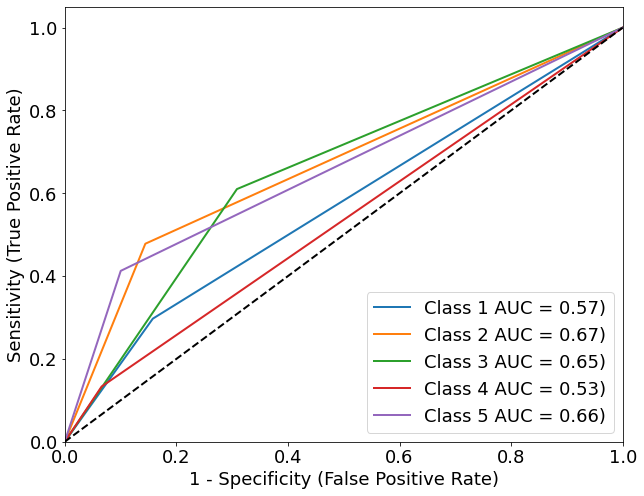

In [39]:
hemoCohort = pd.read_csv("Data Validation/Cardiogenic Shock/Preprocessed Data/CardiogenicShock_Hemo.csv", sep=",", index_col='ID')
deathLabels = hemoCohort['ScoreDeath']

hemo = hemoCohort.drop('ScoreDeath', axis=1)
hemo = hemo.drop('Score', axis=1)
hemo = hemo.drop('ScoreRehosp', axis=1)
hemo = hemo.drop('ScoreReadmission', axis=1)
hemo = hemo.replace(np.inf, 0)
hemo = hemo.fillna(0)

#get predicted scores from model
performValidation(model=testModel, data=hemo, realScores=deathLabels, aucName='HemoCardShockDeLvTx')

### Serial Cardiac

In [40]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/Hemo_Death')


*****MVDD Validation*****
y_pred [2 2 2 2 5 3 3 3 2 2 5 5 5 2 2 2 2 2 2 2 2 2 5 3 3 3 3 2 1 1 1 3 3 3 5 4 3
 5 5 2 3 3 1 3 2 2 2 2 2 2 2 2 2 2 2 4 4 2 2 2 3 1 3 3 4 3 1 1 1 4 4 3 2 2
 2 5 2 2 2 5 5 1 1 1 3 3 1 3 3 1 1 4 1 5 5 4 3 3 3 3 3 3 3 3 5 5 5 5 3 3 4
 4 3 3 4 4 3 1 4 1 3 3 3 2 2 2 2 3 3 1 1 3 1 1 1 5 5 5 3 3 3 1 1 3 2 2 2 2
 2 2 2 5 1 1 1 1 3 3 3 2 2 2 2 2 2 5 5 5 5 5 5 3 3 3 3 5 5 4 4 4 4 2 2 1 3
 5 5 5 5 3 3 3 1 3 4 4 1 1 2 5 2 5 5 4 4 2 2 1 3 1 1 1 1 5 5 5 5 5 1 1 4 4
 4 3 5 5 5 3 3 2 2 5 5 5 5 1 3 1 4 1 1 3 1 3 3 3 3 3 3 3 1 5 2 5 2 2 2 2 3
 3 3 3 1 1 1 1 2 2 2 2 2 2 4 3 3 3 3 1 3 3 1 3 3 2 3 3 5 4 4 3 3 3 4 4 3 3
 3 3 3 3 1 3 3 3 3 3 3 3 3 1 3 3 2 2 5 5 3 1 3 3 1 3 3 5 5 5 1 1 1 1 1 1 1
 3 4 1 1 1 3 4 3 1 1 3 3 3 5 5 5 3 1 4 4 3 3 3 1 5 1 1 3 3 3 4 4 1 1 3 3 5
 5 5 5 5 5 5 5 2 5 1 1 1 1 1 1 3 1 1 1 3 3 2 2 3 3 3 2 2 2 2 2 2 2 3 3 1 3
 3 3 3 2 2 5 3 3 1 1 1 5 5 1 3 3 3 4 4 4 5 5 5 5 3 3 3 3 1 2 2 2 2 2 2 2 2
 2 2 2 3 3 3 1 1 5 2 1 3 3 3 1 1 3 3 2 5 5 5 3 3 3 2 2 2 5 5 5 5 2

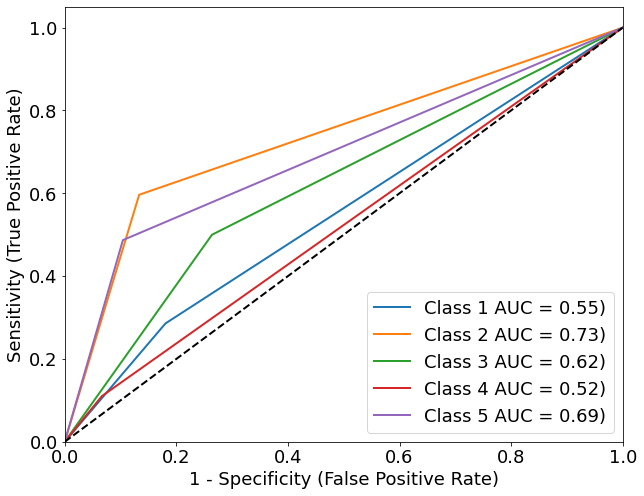

In [41]:
hemoCohort = pd.read_csv("Data Validation/Serial Cardiac Caths/Preprocessed Data/SerialCardiac_Hemo.csv", sep=",", index_col='ID')
deathLabels = hemoCohort['ScoreDeath']

hemo = hemoCohort.drop('ScoreDeath', axis=1)
hemo = hemo.drop('Score', axis=1)
hemo = hemo.drop('ScoreRehosp', axis=1)
hemo = hemo.drop('ScoreReadmission', axis=1)
hemo = hemo.replace(np.inf, 0)
hemo = hemo.fillna(0)

#get predicted scores from model
performValidation(model=testModel, data=hemo, realScores=deathLabels, aucName='HemoSerialCardiacDeLvTx')

## Label = Rehosp


### Cardiogenic Shock

In [4]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/Hemo_Rehosp')


*****MVDD Validation*****
y_pred [5 3 3 4 4 5 1 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 3 5 5 5 5 5 5 3 5 5 3 5
 5 5 5 5 5 5 5 5 5 4 4 3 5 5 5 5 5 5 3 3 3 3 3 1 1 1 1 4 4 4 4 5 5 5 5 5 4
 4 4 3 4 5 5 3 3 4 4 1 4 5 5 5 4 4 3 5 4 5 5 5 5 5 3 3 5 5 5 3 3 3 3 3 3 3
 5 3 5 5 3 4 5 5 5 5 5 5 5 5 5 5 5 4 3 5 5 5 5 5 5 5 5 5 3 3 3 5 5 3 3 3 5
 5 3 3 3 5 5 5 3 3 3 5 3 5 5 4 5 4 4 5 3 3 5 3 5 5 5 3 5 5 3 3 4 4 4 4 4 4
 4 4 5 3 5 5 5 5 5 5 5 4 4 4 4 4 4 3 3 5 3 5 4 5 5 5 4 4 4 4 4 4 3 4 4 4 4
 5 5 3 5 5 3 5 4 4 4 3 3 5 4 4 4 4 4 4 3 3 3 3 3 4 4 4 5 4 4 4 4 1 4 1 1 1
 1 1 4 3 5 5 5 5 5 5 5 3 5 5 5 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5
 3 3 3 3 5 4]


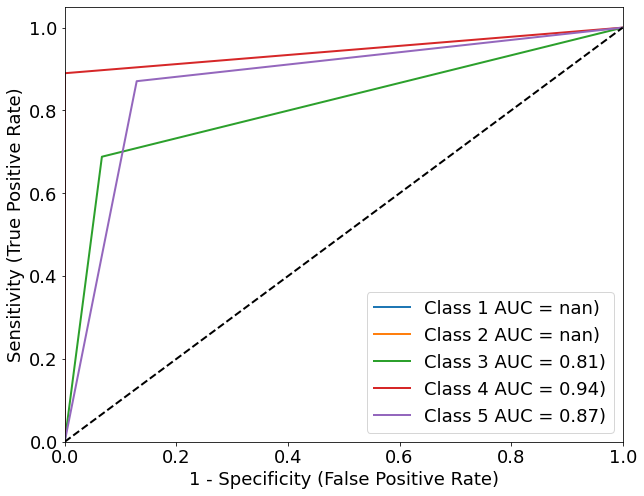

Sensitivity (TPR): 0.816(±0.182)
Specificity (TNR): 0.941(±0.094)
Precision (PPV): 0.647(±0.766)
Negative Predictive Value (NPV): 0.939(±0.078)
FPR: 0.059(±0.094)
FNR: 0.184(±0.182)
Accuracy: 0.916(±0.089)
Averaged AUC: 0.876(±0.110)


In [5]:
hemoCohort = pd.read_csv("Data Validation/Cardiogenic Shock/Preprocessed Data/CardiogenicShock_Hemo.csv", sep=",", index_col='ID')
deathLabels = hemoCohort['ScoreRehosp']

hemo = hemoCohort.drop('ScoreRehosp', axis=1)
hemo = hemo.drop('Score', axis=1)
hemo = hemo.drop('ScoreDeath', axis=1)
hemo = hemo.drop('ScoreReadmission', axis=1)
hemo = hemo.replace(np.inf, 0)
hemo = hemo.fillna(0)

#get predicted scores from model
performValidation(model=testModel, data=hemo, realScores=deathLabels, aucName='HemoCardShockRehosp')

### Serial Cardiac

In [5]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/Hemo_Rehosp')


*****MVDD Validation*****


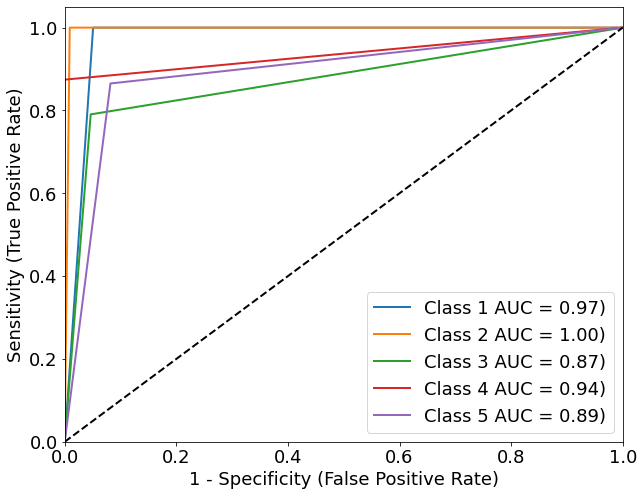

Sensitivity (TPR): 0.906(±0.164)
Specificity (TNR): 0.962(±0.060)
Precision (PPV): 0.607(±0.720)
Negative Predictive Value (NPV): 0.957(±0.071)
FPR: 0.038(±0.060)
FNR: 0.094(±0.164)
Accuracy: 0.940(±0.064)
Averaged AUC: 0.934(±0.094)


In [6]:
hemoCohort = pd.read_csv("Data Validation/Serial Cardiac Caths/Preprocessed Data/SerialCardiac_Hemo.csv", sep=",", index_col='ID')
deathLabels = hemoCohort['ScoreRehosp']

hemo = hemoCohort.drop('ScoreRehosp', axis=1)
hemo = hemo.drop('Score', axis=1)
hemo = hemo.drop('ScoreDeath', axis=1)
hemo = hemo.drop('ScoreReadmission', axis=1)
hemo = hemo.replace(np.inf, 0)
hemo = hemo.fillna(0)

#get predicted scores from model
performValidation(model=testModel, data=hemo, realScores=deathLabels, aucName='HemoSerialCardiacRehosp')

# All Data Model Validation

## Label = Death
Note: All Validation Datasets have the death label

### BEST All Data Validation

In [9]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_Death')


*****MVDD Validation*****
y_pred [3 1 1 ... 3 1 3]
Sensitivity (TPR): 0.990 +/- 0.037
Specificity (TNR): 0.998 +/- 0.037
Precision (PPV): 0.856 +/-  0.032
Negative Predictive Value (NPV): 0.997 +/- 0.037
FPR: 0.002 +/- 0.037
FNR: 0.010 +/- 0.037
Accuracy: 0.997 +/- 0.037
Averaged AUC: 0.994 +/- 0.037


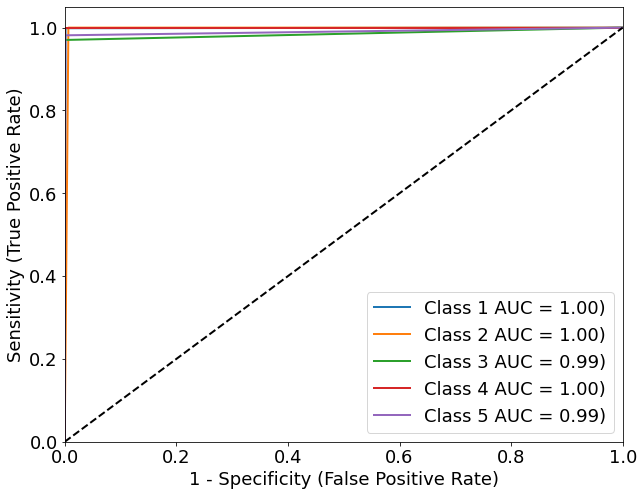

In [10]:
guideAllData = pd.read_csv("Data Validation/BEST/Preprocessed Data/BEST_AllData.csv", sep=",", index_col='ID')
deathLabels = guideAllData['ScoreDeath']

allD = guideAllData.drop('ScoreDeath', axis=1)
allD = allD.drop('Score', axis=1)
allD = allD.drop('ScoreRehosp', axis=1)
allD = allD.drop('ScoreReadmission', axis=1)
allD = allD.replace(np.inf, 0)
allD = allD.fillna(0)

#get predicted scores from model
performValidation(model=testModel, data=allD, realScores=deathLabels, aucName='AllDataBestDeLvTx')

### GUIDE-IT All Data Validation

In [11]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_Death')


*****MVDD Validation*****
y_pred [1 3 3 1 3 2 1 3 2 3 1 4 1 3 2 1 3 2 1 3 2 1 3 2 1 3 2 1 3 2 1 3 2 1 1 4 1
 4 3 2 2 2 3 2 3 2 3 2 3 3 3 2 3 2 1 4 1 4 3 2 1 4 3 2 3 2 3 2 3 2 3 2 1 4
 3 3 3 2 3 2 3 2 3 2 3 2 3 3 1 4 1 4 1 4 1 4 4 4 3 3 3 2 5 5 3 2 3 2 3 3 3
 2 3 2 3 2 1 4 1 4 1 4 1 4 3 2 3 2 1 4 1 4 3 2 3 2 3 3 3 2 3 2 1 4 1 4 1 4
 3 2 1 4 3 2 3 2 3 2 3 2 3 2 1 4 3 2 2 2 3 2 4 4 1 4 1 4 3 2 3 2 3 2 3 2 3
 2 3 2 3 2 3 2 1 4 1 4 1 4 1 4 1 4 1 4 3 2 1 5 1 4 1 1 3 2 1 4 5 4 3 2 1 4
 3 2 1 4 3 2 3 2 1 4 3 2 3 2 3 2 3 2 3 2 5 4 3 3 1 4 3 2 5 4 3 2 1 4 3 2 3
 2 1 4 3 3 3 2 3 2 1 4 3 2 1 4 3 2 3 2 3 2 1 4 3 2 3 2 1 4 3 2 3 2 3 2 1 4
 3 2 3 2 3 2 3 2 1 4 1 4 1 4 3 3 3 2 3 2 3 2 1 4 3 2 3 2 1 4 1 4 1 1 3 2 3
 2 3 2 3 2 3 2 1 4 3 2 1 4 3 2 3 2 3 2 3 3 3 3 3 2 1 4 1 4 3 2 3 2 3 2 1 4
 1 4 1 4 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 1 4 1 4 1 4 1 4 3 2 3 2 1 4 3 3 3
 2 3 2 1 4 3 2 1 4 1 4 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 1 4 3 2 3 2 3 2 3 2
 1 4 3 2 1 4 3 2 3 2 3 2 1 4 3 2 3 3 3 2 1 4 1 4 1 4 3 2 4 4 3 2 1

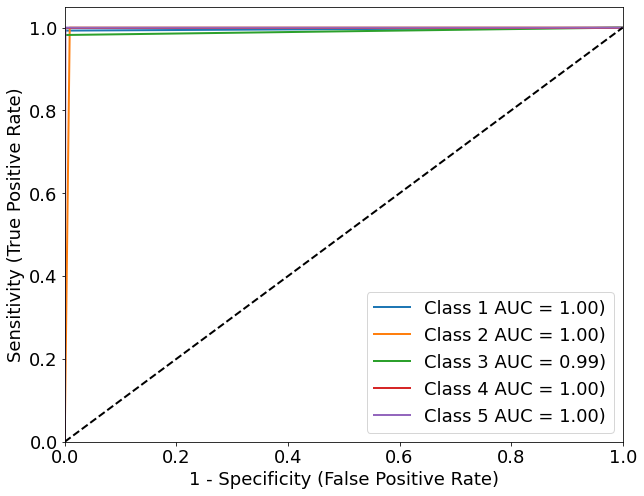

In [12]:
guideAllData = pd.read_csv("Data Validation/GUIDE-IT/Preprocessed Data/GUIDE-IT_AllData.csv", sep=",", index_col='ID')
deathLabels = guideAllData['ScoreDeath']

allD = guideAllData.drop('ScoreDeath', axis=1)
allD = allD.drop('Score', axis=1)
allD = allD.drop('ScoreRehosp', axis=1)
allD = allD.drop('ScoreReadmission', axis=1)
allD = allD.replace(np.inf, 0)
allD = allD.fillna(0)

#get predicted scores from model
performValidation(model=testModel, data=allD, realScores=deathLabels, aucName='AllDataGuideItDeLvTx')

### Cardiogenic Shock All Data Validation

In [13]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_Death')


*****MVDD Validation*****
y_pred [1 4 4 ... 3 2 2]
Sensitivity (TPR): 0.811 +/- 0.045
Specificity (TNR): 0.931 +/- 0.054
Precision (PPV): 0.780 +/-  0.043
Negative Predictive Value (NPV): 0.929 +/- 0.053
FPR: 0.069 +/- 0.054
FNR: 0.189 +/- 0.045
Accuracy: 0.865 +/- 0.049
Averaged AUC: 0.871 +/- 0.050


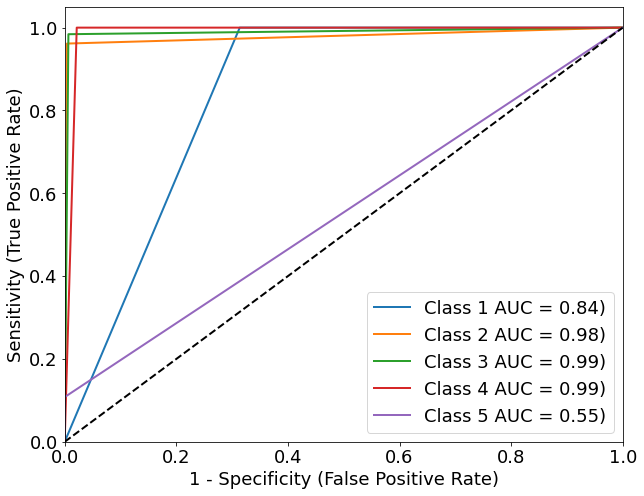

In [14]:
allDataCohort = pd.read_csv("Data Validation/Cardiogenic Shock/Preprocessed Data/CardiogenicShock_AllData.csv", sep=",", index_col='ID')
deathLabels = allDataCohort['ScoreDeath']

ad = allDataCohort.drop('ScoreDeath', axis=1)
ad = ad.drop('Score', axis=1)
ad = ad.drop('ScoreRehosp', axis=1)
ad = ad.drop('ScoreReadmission', axis=1)
ad = ad.replace(np.inf, 0)
ad = ad.fillna(0)

#get predicted scores from model
performValidation(model=testModel, data=ad, realScores=deathLabels, aucName='AllDataCardShockDeLvTx')

### Serial Cardiac All Data Validation

In [15]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_Death')


*****MVDD Validation*****
y_pred [3 2 2 3 3 2 2 2 2 5 1 1 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 3 3 3 1 1 1 1
 1 5 3 3 2 1 4 4 3 3 3 5 4 4 1 1 4 3 3 3 3 3 3 2 2 2 5 1 1 3 3 3 1 1 1 1 1
 1 1 1 1 5 4 4 3 3 2 3 3 3 3 3 3 1 1 1 1 4 4 1 1 4 1 1 1 1 1 4 3 3 3 4 1 1
 5 4 4 3 3 3 1 1 4 1 1 4 1 1 1 5 5 1 5 5 1 3 3 3 5 1 1 5 1 1 1 1 1 3 3 3 1
 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 1 1 1 5 5 4 4 4 4 3 3 2 3 3 3 3 3
 3 1 5 4 1 5 4 2 2 2 1 1 1 1 1 4 3 3 3 5 5 5 4 4 4 3 3 3 5 1 1 1 1 1 1 1 1
 5 4 4 3 3 2 3 3 2 3 3 3 1 1 1 3 2 2 5 1 4 5 5 5 3 3 3 1 5 4 4 4 4 4 4 4 3
 3 3 1 4 4 3 3 3 3 2 2 3 2 2 3 3 2 1 4 4 1 4 4 1 1 5 1 1 4 1 1 1 5 4 4 5 5
 4 4 4 4 3 3 3 3 3 2 1 5 5 5 4 1 3 3 3 3 2 2 1 1 1 1 1 1 1 1 1 5 5 1 2 2 2
 1 1 1 3 3 2 1 4 4 1 1 4 5 5 5 3 2 2 3 3 3 1 4 4 4 4 4 1 4 4 1 4 4 2 2 2 3
 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 1 4 4 4 1 1 2 2 2 1 1 1 1 1 4 1 4
 4 4 1 1 1 4 4 1 1 5 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 1 4 1 4 4 3 2 2 1 4 4
 3 2 2 3 2 2 3 3 3 5 1 1 1 4 4 3 3 3 3 3 3 1 1 1 3 2 2 1 1 1 3 3 3

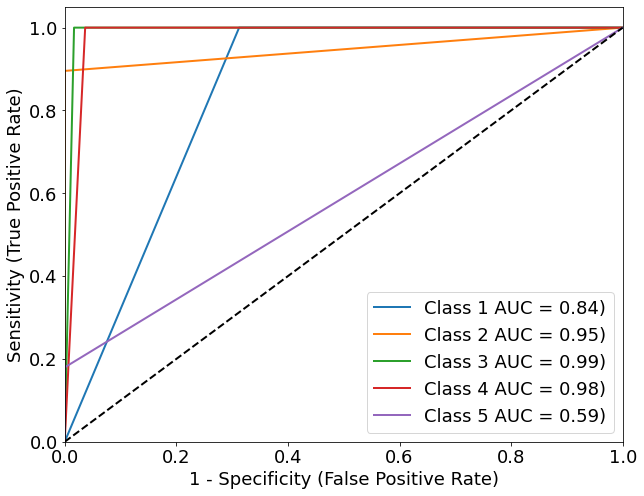

In [16]:
allDataCohort = pd.read_csv("Data Validation/Serial Cardiac Caths/Preprocessed Data/SerialCardiac_AllData.csv", sep=",", index_col='ID')
deathLabels = allDataCohort['ScoreDeath']

ad = allDataCohort.drop('ScoreDeath', axis=1)
ad = ad.drop('Score', axis=1)
ad = ad.drop('ScoreRehosp', axis=1)
ad = ad.drop('ScoreReadmission', axis=1)
ad = ad.replace(np.inf, 0)
ad = ad.fillna(0)

#get predicted scores from model
performValidation(model=testModel, data=ad, realScores=deathLabels, aucName='AllDataSerialCardiacDeLvTx')

## Label = Rehospitalization
Note: Only HF-ACTION, BEST and GUIDE-IT have rehosp

### BEST All Data Validation

In [17]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_Rehosp')


*****MVDD Validation*****
y_pred [4 3 3 ... 4 3 4]
Sensitivity (TPR): 0.990 +/- 0.037
Specificity (TNR): 0.998 +/- 0.037
Precision (PPV): 0.856 +/-  0.032
Negative Predictive Value (NPV): 0.997 +/- 0.037
FPR: 0.002 +/- 0.037
FNR: 0.010 +/- 0.037
Accuracy: 0.997 +/- 0.037
Averaged AUC: 0.994 +/- 0.037


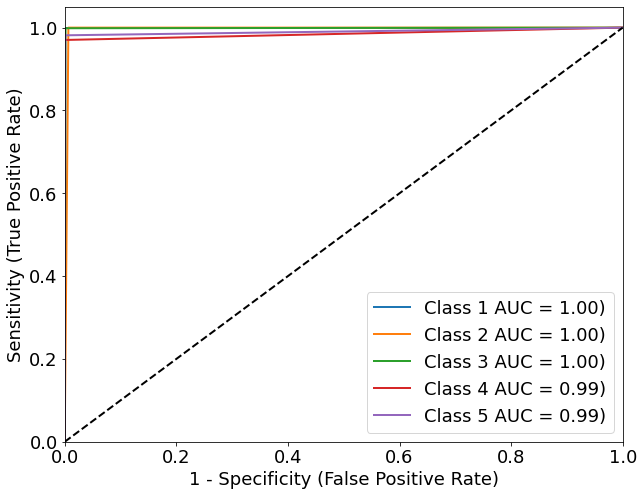

In [18]:
guideAllData = pd.read_csv("Data Validation/BEST/Preprocessed Data/BEST_AllData.csv", sep=",", index_col='ID')
labels = guideAllData['ScoreRehosp']

allD = guideAllData.drop('ScoreDeath', axis=1)
allD = allD.drop('Score', axis=1)
allD = allD.drop('ScoreRehosp', axis=1)
allD = allD.drop('ScoreReadmission', axis=1)
allD = allD.replace(np.inf, 0)
allD = allD.fillna(0)

#get predicted scores from model
performValidation(model=testModel, data=allD, realScores=labels, aucName='AllDataBestRehosp')

### GUIDE-IT All Data Validation

In [19]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_Rehosp')


*****MVDD Validation*****
y_pred [3 4 4 3 4 2 3 4 2 4 3 1 3 4 2 3 4 2 3 4 2 3 4 2 3 4 2 3 4 2 3 4 2 3 3 1 3
 1 4 2 2 2 4 2 4 2 4 2 4 4 4 2 4 2 3 1 3 1 4 2 3 1 4 2 4 2 4 2 4 2 4 2 3 1
 4 4 4 2 4 2 4 2 4 2 4 2 4 4 3 1 3 1 3 1 3 1 1 1 4 4 4 2 5 5 4 2 4 2 4 4 4
 2 4 2 4 2 3 1 3 1 3 1 3 1 4 2 4 2 3 1 3 1 4 2 4 2 4 4 4 2 4 2 3 1 3 1 3 1
 4 2 3 1 4 2 4 2 4 2 4 2 4 2 3 1 4 2 2 2 4 2 1 1 3 1 3 1 4 2 4 2 4 2 4 2 4
 2 4 2 4 2 4 2 3 1 3 1 3 1 3 1 3 1 3 1 4 2 3 5 3 1 3 3 4 2 3 1 5 1 4 2 3 1
 4 2 3 1 4 2 4 2 3 1 4 2 4 2 4 2 4 2 4 2 5 1 4 4 3 1 4 2 5 1 4 2 3 1 4 2 4
 2 3 1 4 4 4 2 4 2 3 1 4 2 3 1 4 2 4 2 4 2 3 1 4 2 4 2 3 1 4 2 4 2 4 2 3 1
 4 2 4 2 4 2 4 2 3 1 3 1 3 1 4 4 4 2 4 2 4 2 3 1 4 2 4 2 3 1 3 1 3 3 4 2 4
 2 4 2 4 2 4 2 3 1 4 2 3 1 4 2 4 2 4 2 4 4 4 4 4 2 3 1 3 1 4 2 4 2 4 2 3 1
 3 1 3 1 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 3 1 3 1 3 1 3 1 4 2 4 2 3 1 4 4 4
 2 4 2 3 1 4 2 3 1 3 1 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 3 1 4 2 4 2 4 2 4 2
 3 1 4 2 3 1 4 2 4 2 4 2 3 1 4 2 4 4 4 2 3 1 3 1 3 1 4 2 1 1 4 2 3

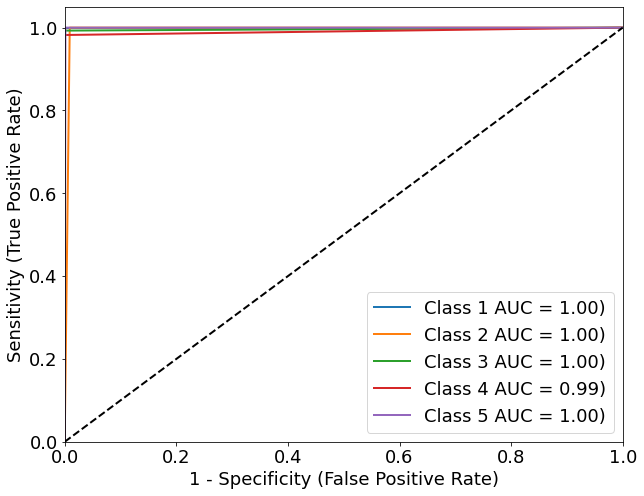

In [20]:
guideAllData = pd.read_csv("Data Validation/GUIDE-IT/Preprocessed Data/GUIDE-IT_AllData.csv", sep=",", index_col='ID')
labels = guideAllData['ScoreRehosp']

allD = guideAllData.drop('ScoreDeath', axis=1)
allD = allD.drop('Score', axis=1)
allD = allD.drop('ScoreRehosp', axis=1)
allD = allD.drop('ScoreReadmission', axis=1)
allD = allD.replace(np.inf, 0)
allD = allD.fillna(0)

#get predicted scores from model
performValidation(model=testModel, data=allD, realScores=labels, aucName='AllDataGuideItRehosp')

### Cardiogenic Shock All Data Validation

In [21]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_Rehosp')


*****MVDD Validation*****
y_pred [3 1 1 ... 4 2 2]
Sensitivity (TPR): 0.250 +/- 0.041
Specificity (TNR): 0.816 +/- 0.046
Precision (PPV): 0.395 +/-  0.026
Negative Predictive Value (NPV): 0.811 +/- 0.045
FPR: 0.184 +/- 0.046
FNR: 0.750 +/- 0.041
Accuracy: 0.694 +/- 0.036
Averaged AUC: 0.533 +/- 0.015


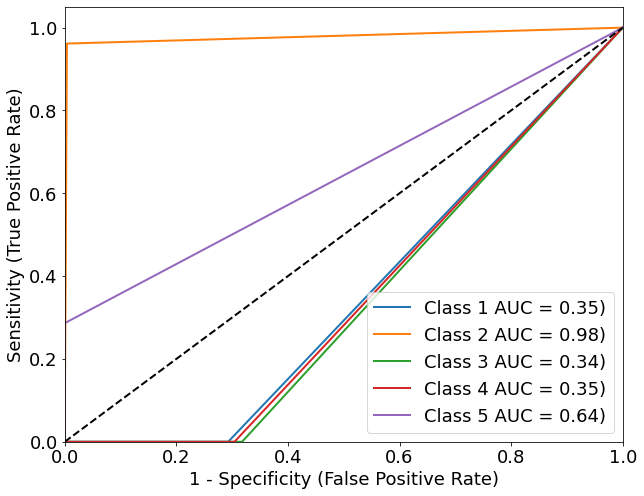

In [22]:
allDataCohort = pd.read_csv("Data Validation/Cardiogenic Shock/Preprocessed Data/CardiogenicShock_AllData.csv", sep=",", index_col='ID')
deathLabels = allDataCohort['ScoreDeath']

ad = allDataCohort.drop('ScoreRehosp', axis=1)
ad = ad.drop('Score', axis=1)
ad = ad.drop('ScoreDeath', axis=1)
ad = ad.drop('ScoreReadmission', axis=1)
ad = ad.replace(np.inf, 0)
ad = ad.fillna(0)

#get predicted scores from model
performValidation(model=testModel, data=ad, realScores=deathLabels, aucName='AllDataCardShockRehosp')

### Serial Cardiac All Data Validation

In [23]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_Rehosp')


*****MVDD Validation*****
y_pred [4 2 2 4 4 2 2 2 2 5 3 3 4 4 2 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 4 4 4 3 3 3 3
 3 5 4 4 2 3 1 1 4 4 4 5 1 1 3 3 1 4 4 4 4 4 4 2 2 2 5 3 3 4 4 4 3 3 3 3 3
 3 3 3 3 5 1 1 4 4 2 4 4 4 4 4 4 3 3 3 3 1 1 5 5 1 3 3 3 3 3 1 4 4 4 1 5 5
 5 1 1 4 4 4 3 3 1 3 3 1 3 3 3 5 5 5 5 5 5 4 4 4 5 3 3 5 3 3 3 3 3 4 4 4 3
 3 3 5 5 5 4 4 4 4 4 4 4 4 4 4 2 2 2 2 2 3 3 3 5 5 1 1 1 1 4 4 2 4 4 4 4 4
 4 3 5 1 3 5 1 2 2 2 3 3 3 3 3 1 4 4 4 5 5 5 1 1 1 4 4 4 5 5 5 3 3 3 3 3 3
 5 1 1 4 4 2 4 4 2 4 4 4 3 3 3 4 2 2 5 3 1 5 5 5 4 4 4 3 5 1 1 1 1 1 1 1 4
 4 4 5 1 1 4 4 4 4 2 2 4 2 2 4 4 2 3 1 1 3 1 1 5 5 5 3 3 1 3 3 3 5 1 1 5 5
 1 1 1 1 4 4 4 4 4 2 5 5 5 5 1 3 4 4 4 4 2 2 5 5 5 5 5 5 3 3 3 5 5 5 2 2 2
 5 5 5 4 4 2 3 1 1 3 3 1 5 5 5 4 2 2 4 4 4 3 1 1 1 1 1 3 1 1 3 1 1 2 2 2 4
 2 2 3 3 3 3 3 3 5 5 5 5 5 5 3 3 3 4 4 4 3 1 1 1 3 3 2 2 2 3 3 3 5 5 1 5 1
 1 1 3 3 5 1 1 3 3 5 4 4 4 4 4 4 4 4 4 1 1 1 1 1 1 1 5 1 3 1 1 4 2 2 3 1 1
 4 2 2 4 2 2 4 4 4 5 3 3 3 1 1 4 4 4 4 4 4 3 3 3 4 2 2 3 3 3 4 4 4

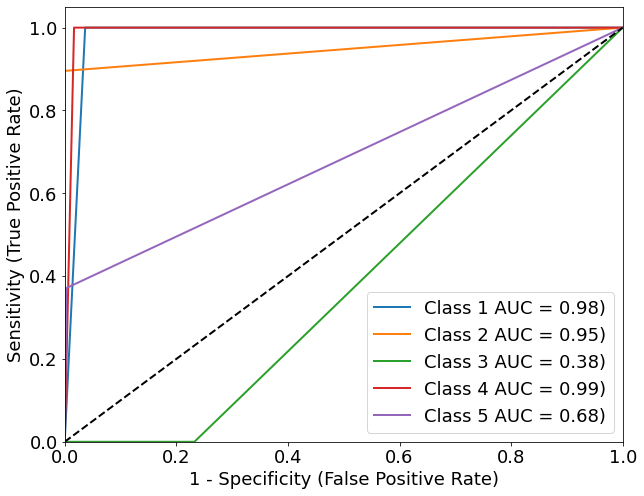

In [24]:
allDataCohort = pd.read_csv("Data Validation/Serial Cardiac Caths/Preprocessed Data/SerialCardiac_AllData.csv", sep=",", index_col='ID')
deathLabels = allDataCohort['ScoreRehosp']

ad = allDataCohort.drop('ScoreRehosp', axis=1)
ad = ad.drop('Score', axis=1)
ad = ad.drop('ScoreDeath', axis=1)
ad = ad.drop('ScoreReadmission', axis=1)
ad = ad.replace(np.inf, 0)
ad = ad.fillna(0)

#get predicted scores from model
performValidation(model=testModel, data=ad, realScores=deathLabels, aucName='AllDataSerialCardiacRehosp')